In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [ ]:
price_history = pd.read_csv('data/ETH_USD_11_20_2020-1_19_2021_historical_prices.csv', sep=';')
whales = pd.read_csv('data/transactions_aggregated_21_22.csv')
validators = pd.read_csv('data/validators_aggregated_21_22.csv')

# Basic cleaning
whales['date'] = pd.to_datetime(whales['datetime']).dt.date
validators['date'] = pd.to_datetime(validators['datetime']).dt.date

## Price history in price deltas includes datetime, price delta, and eth_volume
price_deltas = price_history.copy()[['timeOpen', 'close', 'volume']]
# price_deltas['delta'] = price_deltas['close'].diff().shift(-1)
price_deltas['delta'] = price_deltas['close'].pct_change()                  # Percent change function here
price_deltas['date'] = pd.to_datetime(price_deltas['timeOpen']).dt.date

Percentiles (20th, 40th, 60th, 80th): [-0.02726268 -0.00783     0.00603285  0.02485177]


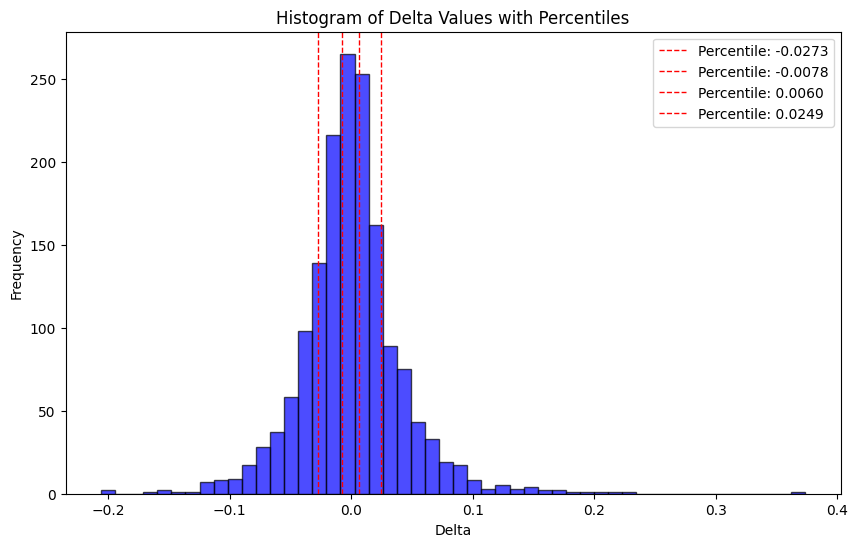

In [56]:
# Calculate the percentiles
percentiles = np.percentile(price_deltas['delta'].dropna(), [20, 40, 60, 80])
print("Percentiles (20th, 40th, 60th, 80th):", percentiles)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(price_deltas['delta'].dropna(), bins=50, alpha=0.7, color='blue', edgecolor='black')
for p in percentiles:
    plt.axvline(p, color='red', linestyle='dashed', linewidth=1, label=f'Percentile: {p:.4f}')
plt.title('Histogram of Delta Values with Percentiles')
plt.xlabel('Delta')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
# Apply labels to shift, with 5 classifications -2:2
labels = [-2, -1, 0, 1, 2]
# levels = [-np.inf, -0.05, -0.01, 0.01, 0.05, np.inf]
levels = [-np.inf, percentiles[0], percentiles[1], percentiles[2], percentiles[3], np.inf]

price_deltas['labels'] = pd.cut(x=price_deltas['delta'], bins=levels, labels=labels)

In [36]:
# TODO: Control center for aggregation strategy switching

# Aggregate whales
whale_aggregated = whales.groupby('date').agg(
    whale_avg_valueEth=('valueETH', 'mean'),
    whale_var_valueEth=('valueETH', 'var'),
    whale_avg_gasPrice=('gasPrice', 'mean')
)

# Aggregate validators
validators_aggregated = validators.groupby('date').agg(
    validator_count=('blockHash', 'nunique'),
    validator_gas_price=('gasPrice', 'mean'),
)

print(price_deltas.head())
print(whale_aggregated.head())
print(validators_aggregated.head())

                   timeOpen        close        volume     delta        date  \
0  2025-04-23T00:00:00.000Z  1796.104189  2.290464e+10       NaN  2025-04-23   
1  2025-04-22T00:00:00.000Z  1757.331703  2.374792e+10 -0.021587  2025-04-22   
2  2025-04-21T00:00:00.000Z  1579.734556  1.540379e+10 -0.101061  2025-04-21   
3  2025-04-20T00:00:00.000Z  1587.514228  7.642784e+09  0.004925  2025-04-20   
4  2025-04-19T00:00:00.000Z  1612.922809  7.168139e+09  0.016005  2025-04-19   

  labels  
0    NaN  
1     -1  
2     -2  
3      0  
4      1  
            whale_avg_valueEth  whale_var_valueEth  whale_avg_gasPrice
date                                                                  
2021-01-01         9420.615145        2.907903e+08        9.104290e+10
2021-01-02         5493.719855        2.406098e+07        1.310462e+11
2021-01-03        13325.784826        1.492609e+08        2.976456e+11
2021-01-04        18190.842405        1.977588e+08        3.516557e+11
2021-01-05        10509.542

In [37]:
# Dataset merging left onto labels
_intermediate = pd.merge(
    price_deltas,
    whale_aggregated,
    on='date',
    how='left'
)

labeled_data = pd.merge(
    _intermediate,
    validators_aggregated,
    on='date',
    how='left'
)

In [38]:
# Do checks, pull off final month of 2022 for testing
labeled_data.sort_values(by='date', inplace=True, ascending=True) 
labeled_data.dropna(inplace=True)

# Split into train and test
y = labeled_data['labels']
X = labeled_data[['whale_avg_valueEth', 'whale_var_valueEth', 'whale_avg_gasPrice', 'validator_count', 'validator_gas_price']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Train Accuracy: 0.28542094455852157
Test Accuracy: 0.27049180327868855


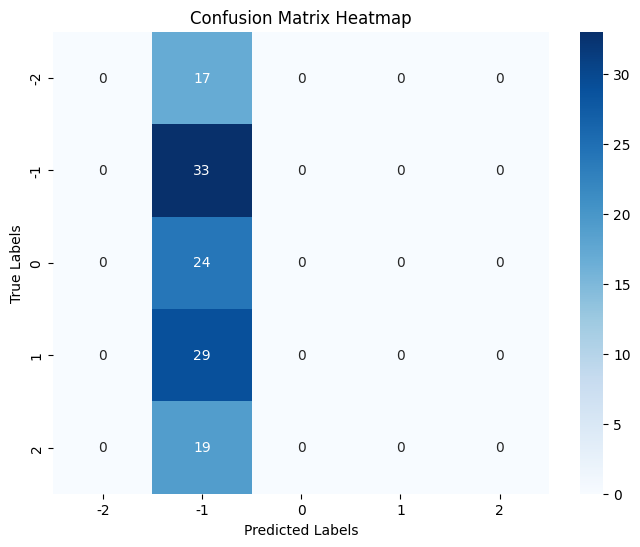

In [54]:
# model = LogisticRegression(max_iter=1000, random_state=42) ## 40% Test
model = MLPClassifier([24, 24, 24], max_iter=10000, random_state=42, solver='adam', activation='logistic') ## 50% Test


# Fit the model on the training data
model.fit(X_train, y_train)

# Predict on training and test data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred, labels=labels)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()